In [2]:
import random
from pathlib import Path
import re
from typing import List, Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torchtext
import torchtext.vocab
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torchtext.data.utils import get_tokenizer
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")
torchtext.disable_torchtext_deprecation_warning()
warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

filename = 'fake_and_real_news_dataset.csv'
datapath = Path.cwd().parent / 'data' / filename
sentences = pd.read_csv(str(datapath))['title']

"""
generate vocabulary
"""

sentences = sentences.dropna()
sentences = sentences.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

tokenizer = get_tokenizer('basic_english')
tokenized_sentences = [tokenizer(s) for s in sentences]

features_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2, # minimum frequency of a word to be included in the vocabulary
    specials=['<pad>', '<oov>'], # pad = padding, oov = out of vocabulary
    special_first=True
)
target_vocab = torchtext.vocab.build_vocab_from_iterator(
    tokenized_sentences,
    min_freq=2
)
print(f"{len(features_vocab)=}, {len(target_vocab)=}, {features_vocab['<pad>']=}, {features_vocab['<oov>']=}")


"""
encode sentences to ngrams of vocabulary indices
"""

def encode_to_vocab_idx(tokenized_sentences: List[str]) -> List[List[int]]:

    def _get_ngrams(tokenized_sentence: List[str]) -> List[List[str]]:
        # example: "hello beautiful world" -> ["hello", "hello beautiful", "hello beautiful world"]
        return [tokenized_sentence[:i+1] for i in range(1, len(tokenized_sentence))]

    def _add_random_oov_tokens(ngram: List[str]) -> List[str]:
        # replace 10% of tokens with <oov> token to simulate the presence of out-of-vocabulary words    
        return ['<oov>' if random.uniform(0, 1) < 0.1 else token for token in ngram[:-1]]

    def _encode_to_vocab_idx(tokenized_sentence: List[str]) -> Optional[List[int]]:
        # encode by replacing each token with its index in the vocabulary
        tokens_list = []
        if tokenized_sentence[-1] in target_vocab.get_itos():
            for token in tokenized_sentence[:-1]:
                num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>'] # features from features_vocab
                tokens_list.append(num_token)
            num_token = target_vocab[tokenized_sentence[-1]] # target (last token) from target_vocab
            tokens_list.append(num_token)
            return tokens_list
        
        # target token is not in the vocabulary
        return None

    def _pad_sequence(sequence: List[int]) -> List[int]:
        # pad the sequence to the length of the longest sequence
        return F.pad(torch.tensor(sequence), (0, longest_sequence_feature - len(sequence)), value=features_vocab['<pad>'])

    ngrams_list = [ngram for ts in tokenized_sentences for ngram in _get_ngrams(ts)]
    ngrams_list_oov = list(map(_add_random_oov_tokens, ngrams_list))
    encoded_sequences = list(filter(None, [_encode_to_vocab_idx(sequence) for sequence in ngrams_list_oov]))
    padded_sequences = list(map(_pad_sequence, encoded_sequences))
    
    longest_sequence_feature = max([len(sequence) for sequence in tokenized_sentences])
    print(f'{len(ngrams_list)=}, {len(ngrams_list_oov)=}, {len(encoded_sequences)=}, {len(padded_sequences)=}')

    return padded_sequences

input_sequences = encode_to_vocab_idx(tokenized_sentences)
X = [sequence[:-1] for sequence in input_sequences]
y = [sequence[-1] for sequence in input_sequences]

print(f'{len(X)=}, {len(y)=}')

len(features_vocab)=3917, len(target_vocab)=3915, features_vocab['<pad>']=0, features_vocab['<oov>']=1


KeyboardInterrupt: 

In [ ]:
class My_LSTM(nn.Module):
    def __init__(self, features_vocab_total_words, target_vocab_total_words, embedding_dim, hidden_dim):
        super(My_LSTM, self).__init__()
        self.embedding = nn.Embedding(features_vocab_total_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) 
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, target_vocab_total_words)

    def forward(self, x):
        x = x.to(self.embedding.weight.device)
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output


embedding_dim = max([len(sequence) for sequence in tokenized_sentences])
hidden_dim = 200
epochs = 50
model = My_LSTM(len(features_vocab), len(target_vocab), embedding_dim=embedding_dim, hidden_dim=hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)


def calculate_topk_accuracy(model, data_loader, k=3):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            output = model(batch_x)

            # Get top-k predictions
            _, predicted_indices = output.topk(k, dim=1)

            # Check if the correct label is in the top-k predictions
            correct_predictions += torch.any(predicted_indices == torch.argmax(batch_y, dim=1, keepdim=True), dim=1).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy


padded_X = torch.stack(X)
y = torch.tensor(y)

y_one_hot = one_hot(y, num_classes=len(target_vocab))

data = TensorDataset(padded_X, y_one_hot)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
batch_size = 32
train_data, test_data = random_split(data, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


all_accuracies = []
all_losses = []
for epoch in range(epochs):   
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.argmax(dim=1))
        loss.backward()
        optimizer.step()
            
    if epoch % 5 == 0:
        accuracy = calculate_topk_accuracy(model, train_loader)
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Train K-Accuracy: {accuracy * 100:.2f}%')
        all_accuracies.append(accuracy)
        all_losses.append(loss.item())


Epoch 0/50, Loss: 0.0002, Train K-Accuracy: 100.00%
Epoch 5/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 10/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 15/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 20/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 25/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 30/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 35/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 40/50, Loss: 0.0000, Train K-Accuracy: 100.00%
Epoch 45/50, Loss: 0.0000, Train K-Accuracy: 100.00%


# benchmark

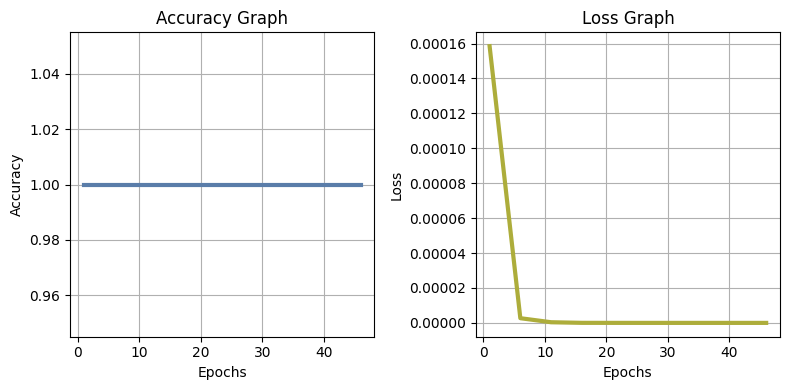

In [ ]:
epoch_list = [i for i in range(1,epochs,5)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4)) 

axes[0].plot(epoch_list, all_accuracies, color='#5a7da9', label='Accuracy', linewidth=3)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Graph')
axes[0].grid(True)
 
axes[1].plot(epoch_list, all_losses, color='#adad3b', label='Accuracy', linewidth=3)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Graph')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
accuracy = calculate_topk_accuracy(model, test_loader)
print(f'Test K-Accuracy: {accuracy * 100:.2f}%')

Test K-Accuracy: 100.00%


In [ ]:
def text_to_numerical_sequence_test(tokenized_text):
    tokens_list = []
    for token in tokenized_text:
        num_token = features_vocab[token] if token in features_vocab.get_itos() else features_vocab['<oov>']
        tokens_list.append(num_token)
    return tokens_list

longest_sequence_feature = max([len(sequence) for sequence in tokenized_sentences])

def use_model(input_list):
    model.eval()
    output_list = []
    for data in input_test:
        sentence = data[0]
        num_words = data[1]
        for i in range(num_words):
            output_of_model = []
            tokenized_input_test = tokenizer(sentence)
            tokenized_sequence_input_test = text_to_numerical_sequence_test(tokenized_input_test)
            padded_tokenized_sequence_input_test = F.pad(torch.tensor(tokenized_sequence_input_test), (longest_sequence_feature - len(tokenized_sequence_input_test)-1, 0), value=0)
            output_test_walking = torch.argmax(model(padded_tokenized_sequence_input_test.unsqueeze(0)))
            sentence = sentence + ' ' + target_vocab.lookup_token(output_test_walking.item()) # type: ignore
        output_list.append(sentence)
    return output_list

input_test = [['stand', 5], ['deep learning is', 5], ['data cleaning', 4], ['6 ways', 4], ['you did a', 2]]
outputs_model = use_model(input_test)
outputs_model


['stand the the the the the',
 'deep learning is the the the the the',
 'data cleaning the the the the',
 '6 ways the the the the',
 'you did a the the']